# Goals of this notebook are: 

* to identify the best model in terms of F1 score on the training and validation data for the **product type** part of the data. 
* F1 was chosen, as the dataset at hand is imbalanced. 

# Import Libraries

In [1]:
import datetime
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from sklearn.dummy import DummyClassifier
# to run validation on multiple metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.models import save_model


%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# Define Parameter Dictionary

In [3]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'product_type_model_tunning',

    # Parameters general:
    'number_of_classes': len(np.unique(train_descr['Sentiment'])),
    'n_splits': 4,
    'seed': 42,
    'batch_size': 64,
    'epochs': 50,
    'hidden_units': 64,
    # Cross-fold validation:
    'k': 4,
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []

Log results to logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:55


# Train-Test Split

In [4]:
def train_test_split(data, labels):
    """
    Splits the data into train and test data sets.
    One-hot encodes the labels.

    Args: 
        - data - preprocessed text_data
        - labels - sentiments

    Returns: 
        - x_train, y_train_oh - training text data & the corresponding one-hot encoded labels
        - x_test, y_test_oh - test text data & the corresponding one-hot encoded labels
    """
    dimensions_labels = PARAMS['number_of_classes']

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = np.asarray(labels)
    labels = labels[indices]

    training_samples = int(0.8 * len(data))

    x_train = data[:training_samples]
    y_train = labels[:training_samples]

    x_test = data[training_samples:]
    y_test = labels[training_samples:]

    y_train_oh = tf.one_hot(indices=y_train, depth=dimensions_labels)
    y_train_oh = np.asarray(y_train_oh)

    y_test_oh = tf.one_hot(indices=y_test, depth=dimensions_labels)
    y_test_oh = np.asarray(y_test_oh)

    return x_train, y_train_oh, x_test, y_test_oh

In [5]:
data = train_descr.loc[:, 'Product_Type']
labels = train_descr.loc[:, 'Sentiment']

In [6]:
x_train, y_train, x_test, y_test = train_test_split(data, labels)

# Preparation for Model Generation & Training

### Function for Oversampling the Minority Classes

SMOTE = Synthetic Minority Oversampling Technique. It was chosen, because the data set is small and oversampling will, even if synthetically, increase it.

In [7]:
def oversample_smote(x_train, y_train):
    """
    This function produces an oversampled set of train data using SMOTE

    Args: 
        - x_train - imbalanced train features (= text descriptions)
        - y_train - imbalanced train labels (= sentiments)

    Returns: 
        - x_train - oversampled train features (= text descriptions)
        - y_train - oversampled train labels (= sentiments)

    """
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    return x_train, y_train

### Function to Generate the Models

In [8]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [9]:
def generate_model(params_dict):
    """
    This function compiles a model
    Args: 
        - params_dict - dictionary with parameters for the model

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']

    model = models.Sequential()
    model.add(layers.Dense(hidden_units, activation='relu',
                           input_shape=(1, )))
    model.add(layers.Dense(hidden_units, activation='relu'))
    model.add(layers.Dense(hidden_units, activation='relu'))
    model.add(layers.Dense(dimensions_labels, activation='softmax'))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

### Function for Training with Cross-Validation (incl. Upsampling)

* Due to the small data quantity, cross-validation will be used to train the models.
* Furthermore, as the classes are imbalanced, an oversampling will be introduced. ! It is important to generate the training and validation sets BEFORE the upsampling. Otherwise the exact same observations could be present in both the train and validation sets, i.e. data leakage would occur. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization on unseen data. 
* The oversampling will be applied only on the train set in order to ensure that the model generalises well on unseen data (validation set and ultimately test set)

In [10]:
def train_with_cross_val(k, model, train_data, train_labels, epochs, batch_size):
    """
    This function applies a k-fold cross-validation and saves the model history per fold & epoch.
    Args: 
        - k - number of folds
        - model - compiled model
        - train_data - the tokenised, padded and shuffled sequences
        - train_labels - labels 
        - epochs - number of epochs
        - batch_size - batch size
    """
    num_val_samples = len(train_data) // k

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_labels = train_labels[i *
                                  num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_labels = np.concatenate(
            [train_labels[:i * num_val_samples],
             train_labels[(i + 1) * num_val_samples:]],
            axis=0
        )

        partial_train_data = partial_train_data.reshape(-1, 1)

        partial_train_data_ovs, partial_train_labels_ovs = oversample_smote(
            partial_train_data, partial_train_labels)

        history = model.fit(
            partial_train_data_ovs, partial_train_labels_ovs,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_labels),
            # callbacks=tensorboard_callbacks
        )

        np.save(f'history_pr_type_fc_fold_{i}.npy', history.history)

    if saving:
        path = os.path.join(logdir, 'pr_type_fc_fold')
        model.save(path)

### Create the Baseline Model for Comparison

Idea Model: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


* As the Fully Connected NN model's the precision, recall and f1 are calculcated unweighted, precision, recall & f1 are chosen to be macro
* According to the sklearn-documentation this method calculates the metrics for each label, and finds their unweighted mean and does not take label imbalance into account.
* Example documentation for precision: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Note: test_[metric] is validation and therefore comparable to the val_[metric] of the model.

In [11]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [12]:
model_base = DummyClassifier(strategy='most_frequent')

In [13]:
cv = KFold(n_splits=PARAMS['k'], random_state=PARAMS['seed'])

scores = cross_validate(
    model_base, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [14]:
for metric, score in scores.items():
    print(f'Mean {metric}: %.3f (%.3f)' %
          (np.mean(score), np.std(score)))

Mean fit_time: 0.001 (0.000)
Mean score_time: 0.013 (0.000)
Mean test_accuracy: 0.590 (0.023)
Mean test_precision_macro: 0.148 (0.006)
Mean test_recall_macro: 0.250 (0.000)
Mean test_f1_macro: 0.186 (0.005)


# Train the Model

In [15]:
model = generate_model(PARAMS)
train_with_cross_val(
    PARAMS['k'], model, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 8,708
Trainable params: 8,708
Non-trainable params: 0
_________________________________________________________________
processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:55/pr_type_fc_fold/assets


# Evaluate the Model

* The Model is very simple and does not deliver amazing results
* This is most probably due to the fact that there is only one feature and little data
* However, it is still better than the baseline model in terms of val_accuracy and val_f1
* Therefore, it will be used in the multi-input model

In [16]:
history_all_df = pd.DataFrame()

for i in range(PARAMS['k']):
    history = np.load(
        f'history_pr_type_fc_fold_{i}.npy', allow_pickle='TRUE').item()

    history_df = pd.DataFrame(history)

    history_df['f1'] = 2 * history_df.precision * \
        history_df.recall/(history_df.precision + history_df.recall)
    history_df['f1'] = history_df['f1'].fillna(0)
    history_df['val_f1'] = 2 * history_df.val_precision * \
        history_df.val_recall / \
        (history_df.val_precision + history_df.val_recall)
    history_df['val_f1'] = history_df['val_f1'].fillna(0)

    history_all_df = history_all_df.append(history_df)

history_all_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,1.283646,0.347401,0.000000,0.000000,1.136517,0.124214,0.000000,0.000000,0.000000,0.000000
1,1.070445,0.444358,0.497231,0.089738,1.016576,0.887579,0.839674,0.242925,0.152037,0.376829
2,1.014995,0.450133,0.493220,0.141382,0.992189,0.297956,0.839674,0.242925,0.219767,0.376829
3,1.002046,0.453021,0.477197,0.158041,0.868615,0.863208,0.839674,0.242925,0.237444,0.376829
4,0.995219,0.462794,0.494757,0.172923,0.940404,0.306604,0.839674,0.242925,0.256275,0.376829


In [17]:
history_all_df.mean()

loss             0.935918
accuracy         0.492836
precision        0.547978
recall           0.208604
val_loss         0.902156
val_accuracy     0.672862
val_precision    0.637332
val_recall       0.192724
f1               0.301547
val_f1           0.292491
dtype: float64

### Plot Train vs. Validation Metrics

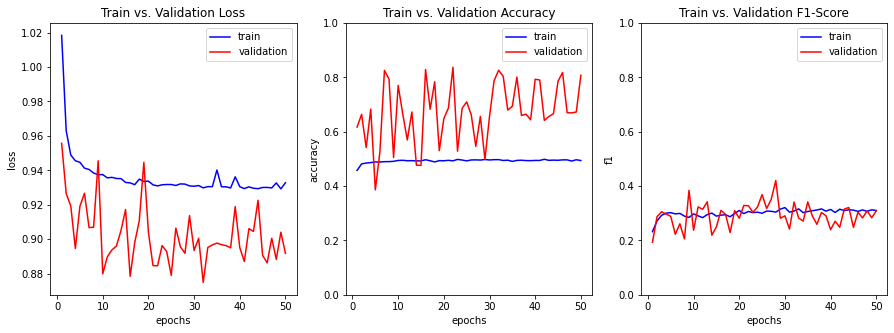

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)

epochs = PARAMS['epochs']
epochs_graph = range(1, PARAMS['epochs'] + 1)
folds = PARAMS['k']

loss_all = history_all_df.loc[:, 'loss'].to_list()
loss_prep = [loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

val_loss_all = history_all_df.loc[:, 'val_loss'].to_list()
val_loss_prep = [
    val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
val_loss = [np.mean([x[i] for x in val_loss_prep]) for i in range(epochs)]

accuracy_all = history_all_df.loc[:, 'accuracy'].to_list()
accuracy_prep = [
    accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
accuracy = [np.mean([x[i] for x in accuracy_prep]) for i in range(epochs)]

val_accuracy_all = history_all_df.loc[:, 'val_accuracy'].to_list()
val_accuracy_prep = [val_accuracy_all[i *
                                      epochs:(i + 1) * epochs] for i in range(folds)]
val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                for i in range(epochs)]

f1_all = history_all_df.loc[:, 'f1'].to_list()
f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

val_f1_all = history_all_df.loc[:, 'val_f1'].to_list()
val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
               for i in range(folds)]
val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

plt.plot(epochs_graph, loss, 'b')
plt.plot(epochs_graph, val_loss, 'r')
#plt.ylim([0, 1])
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Loss')

ax = plt.subplot(132)
plt.plot(epochs_graph, accuracy, 'b')
plt.plot(epochs_graph, val_accuracy, 'r')
plt.ylim([0, 1])
ax.set_ylabel('accuracy')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Accuracy')

ax = plt.subplot(133)
plt.plot(epochs_graph, f1, 'b')
plt.plot(epochs_graph, val_f1, 'r')
plt.ylim([0, 1])
ax.set_ylabel('f1')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation F1-Score')

if logging:
    if not os.path.exists(os.path.join(logdir, 'figures')):
        os.makedirs(os.path.join(logdir, 'figures'))
    fig.savefig(os.path.join(
        logdir, f'figures/loss_accuracy_training_pr_type.png'), bbox_inches='tight')